# This notebook demostrates the augmentation of stellar grid models with Gaussian Process Regression (GPR) models.

# workflow: 

S1: Grid computation/selection: Given a star or a star sample with known observations, we could derive the ranges of inputs parameters. Assuming we are working on the Lund's star sample. We use the scalling relation to derive the mass range of the sample, which is from 0.9 - 1.1 solar mass. We could also know their evolving stages (main-sequence dwarf or early subgiants) by inspecting their locations on the HR diagram. Their metallicities are in a range of [Fe/H] = -0.3 -- 0.3 dex which are from the spectroscopy. Their helium fraction and mixing-length parameter are not unknow. We then use a typical ranges for these two parameters. 

S2: Select training data: Training data should cover the whole parameter sapce and we also need to highly-weighted the areas presenting sharp changes (if there are any).

S3: kernel selection and training data validation: we need a kernel which has proper flexibility to fit the feature of evolutionary tracks. A proper kernel should be able to well reproduece all training data. There could be multiple kernels. 

S4: test data validation: All good kernels will be validated with test data, which contents model data on the grid of training data (but not used for training) as well as model data which are off-grid. If the validation results are not good, go back to S2. There could be a couple iterations from S2 to S4.

S5: When the best model is found, use the validation results to estimate systematical uncertainty (could be another GP model.)



In [1]:
import GPy
import pickle
import numpy as np
import matplotlib #
from numpy import *
from matplotlib import *
import pandas as pd
import warnings
import glob
import random
import time
import re
import os, sys
import csv
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import corner



# The lines below are specific to the notebook format
textsize = 25

%matplotlib inline
params = {'legend.fontsize': textsize,
          'figure.figsize': (12, 10),
         'axes.labelsize': textsize,
         'axes.titlesize':textsize,
         'xtick.labelsize':textsize,
         'ytick.labelsize':textsize,
         'font.size': textsize}
matplotlib.rcParams.update(params)
plt = matplotlib.pyplot

In [2]:
# The global_kernel class is to find GP kernels which are suitable for global stellar parameters (e.g. Teff, Radius) 
#and resample them as a function of the age. 
class global_md_kernel:
    '''
    The global_kernel class aims to find an proper and efficient GP kernel for a global parameter (e. g. Teff) for
    the whole grid.  
    '''
    
    def __init__(self, datapath = None, savepath = None):
        return None
    
    def set_path(self, datapath = None,valipath = None, savepath = None):
        self._datapath = datapath
        self._valipath = valipath
        self._savepath = savepath
        
        if not os.path.exists(datapath):
            raise Warning(f'datapath:' + datapath + ' does not exist')

        if not os.path.exists(valipath):
            raise Warning(f'valipath:' + valipath + ' does not exist')
        
        if not os.path.exists(savepath): os.makedirs(savepath)
        
        print('Data path is set as' + self._datapath)
        print('Validation path is set as' + self._valipath)
        print('Save path is set as' + self._savepath)
        return self
    
    #############################################################################################################
    ################Change this function for different data formats##############################################
    #############################################################################################################
    def get_data_of_a_grid(self, path = None,
                           condition = None, number = None,
                           columns = None,
                           ranges = None,
                           normalization = None):
        if path == None:
            raise Warning(f'$path$ must be given')

        if condition == None:
            warnings.warn(f'$condition$ is missing, all csv files in datapath will be used', UserWarning)
            condition = "*.csv"
        if number == None:
            warnings.warn(f'$number$ is missing, all file will be used', UserWarning)
            number = 9999999999
            
        if (columns == None) or (ranges == None): 
            raise Warning(f'$columns$ and $ranges$ must be given')
        
        #if (validation_frac == None):
        #    warnings.warn(f'$validation_frac$ is missing, 0.2 will be used', UserWarning)
        #    validation_frac = 0.2
    
        all_files = glob.glob(path + condition)
        random.shuffle(all_files)
        n = min([int(number), len(all_files)])
        files= all_files[0:n]
        
        print(str(n) + ' tracks are found')
        
        #print('the columns names are' + str(columns))
        
        df1 = []
        
        for filename in files:
            df0 = self.get_data_of_a_track(filename = filename, 
                                           columns = columns,
                                           ranges = ranges,
                                           normalization =normalization)
            df1.append(df0)
        
        df = []    
        df = pd.concat(df1, ignore_index=True)
        
        #random_state = 1

        #if (len(df['type'])*(1 - validation_frac) >= 10000):
        #    train = df.sample( n = 10000, random_state=random_state) #random state is a seed value
        #else:
        #    train = df.sample(frac = (1 - validation_frac), random_state=random_state) #random state is a seed value
        
        #df['type'].iloc[train.index] = 'data'
        
        return df
    
    
    
    def get_data_of_a_track(self, filename = None, columns = None, ranges = None, normalization = None):
        '''
        '''        
        one_track = []
        one_track = pd.read_csv(filename)
        
        #m = re.search('yinit(.+?)MLT', filename)
        #if m:
        #    found = m.group(1)
        
        #one_track['initial_Yinit'] = float(found)                
        #get rid of the pre-MS
        #one_track = one_track.loc[one_track['center_h1'] <= 0.997*np.max(one_track['center_h1']) ]
        one_track = one_track[columns]
        #one_track['type'] = 'data'
        one_track['hrgradient'] = ((np.gradient(one_track['effective_T']/5777.0))**2.0 
                                 + (np.gradient(one_track['log_g']/4.44))**2.0
                                  )**0.5
        
        one_track['fagegradient'] = np.gradient(one_track['frac_age'])
      
        for i in range(len(columns)):
            #print(columns[i], ranges[i])
            temp = None
            temp = one_track[(one_track[columns[i]] >= min(ranges[i])) & (one_track[columns[i]] <= max(ranges[i]))]
            if (temp.shape[0] >= 10):
                one_track = one_track.loc[temp.index.min(): temp.index.max()]
                one_track['frac_age'] = one_track['star_age']/np.max(one_track['star_age'])
            else:
                one_track = None
                break
            if (normalization != None):
                if (normalization[i] > -999):
                    one_track[columns[i]] = one_track[columns[i]]/normalization[i]
        return one_track
    
    ##################### Plot section########################################################################################
    
    def preview_2d_data(self, condition = None, number = None,
                        x1 = None, x2 = None ,y = None, 
                        x1log = None, x2log = None, ylog = None, 
                        x1normalization = None, x2normalization = None, ynormalization = None,
                        savefig = None):
        
    
        
        plt.figure(figsize=(12, 10))
        plt.xlabel(x)
        plt.ylabel(x2)
        plt.title('Preview of ' + x + ' vs ' + x2 + ' color: ' + y)
        for filename in files:
            print(filename)
            gpx1, gpx2, gpy, gpx1_v, gpx2_v, gpy_v, x1range, x2range, yrange = \
            self.get_data_of_a_track(filename, x1, x2, y, x1log, x2log, ylog, \
                                     x1normalization, x2normalization, 
                                     ynormalization, fraction = 0.9)
            plt.scatter(gpx1, gpx2, c = gpy)
        if (savefig == True): plt.savefig(self._savepath + 'S00_' + x1 + '_vs_' + x2 + '_vs_' + y + 'preview.png')
        return None
    
    def plot_3d_data(self, x = None, y = None, z = None, c = None):
        fig = plt.figure()
        ax = Axes3D(fig)
        cp = ax.scatter(x, y, z, c = c, s=10)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        colorbar = plt.colorbar(cp)
        colorbar.set_label('c')
        return ax, colorbar 
    
    
   
      #####################Data generating#################
    def generate_2d_surface(self, xv = None, xvstep = None, xf1 = None, xf2 = None, number = None, factor = None):
    
        new_xv = []
        new_xf1 = []
        new_xf2 = []
    
        if factor == None: factor = 10
        
        number = min([factor*len(xv), number])
    
        for i in range(int(factor)):
            aa = xv + xvstep*(np.random.random(len(xv))-0.5)
            new_xv = np.concatenate((new_xv, aa))
            new_xf1 = np.concatenate((new_xf1, xf1))
            new_xf2 = np.concatenate((new_xf2, xf2))
            if (len(new_xv) >= number): break
    
        idxs = np.random.choice(arange(len(new_xv)), number)                           
    
    ######################GP models##################
    
    def kernel_bank(self, kname,input_dim):
        if kname == 'RBF': 
            k = GPy.kern.RBF(input_dim=input_dim, variance=1., lengthscale=1., ARD = True)
        elif kname == 'EXP': 
            k = GPy.kern.Exponential(input_dim=input_dim, variance=1., lengthscale=1., ARD = True)
        elif kname == 'MLP': 
            k = GPy.kern.MLP(input_dim=input_dim, ARD = True)
        elif kname == 'MLP+RBF':
            k1 = GPy.kern.MLP(input_dim=input_dim, ARD = True)
            k2 = GPy.kern.RBF(input_dim=input_dim, variance=1., lengthscale=1., ARD = True)
            k = k1+k2
        elif kname == 'MLP+MLP':
            k1 = GPy.kern.MLP(input_dim=input_dim, ARD = True)
            k2 = GPy.kern.MLP(input_dim = input_dim, ARD=True)
            k = k1+k2
        elif kname == 'MLP*MLP':
            k1 = GPy.kern.MLP(input_dim=input_dim, ARD = True)
            k2 = GPy.kern.MLP(input_dim = input_dim, ARD=True)
            k = k1*k2
        elif kname == 'MLP+EXP':
            k1 = GPy.kern.MLP(input_dim=input_dim, ARD = True)
            k2 = GPy.kern.Exponential(input_dim = input_dim, ARD=True)
            k = k1+k2
        elif kname == 'MLP+RQ':
            k1 = GPy.kern.MLP(input_dim=input_dim, ARD = True)
            k2 = GPy.kern.RatQuad(input_dim = input_dim, ARD=True)
            k = k1+k2
        elif kname == 'RQ':
            k = GPy.kern.RatQuad(input_dim = input_dim, ARD=True)
        elif kname == 'Mat32':
            k = GPy.kern.Matern32(input_dim = input_dim, ARD=True)
        else: 
            k = None
        return k

    
    def gp_a_dataframe(self, df = None, xcolumns = None, ycolumns = None, kname = None):
        
        start_time = time.time()
        nx = len(xcolumns)
        ny = len(ycolumns)
        #if (ny != 1):
        #    raise Warning(f'y must be 1 dimession!')

        if (nx>1):
            xx = df[xcolumns].to_numpy()
        else:
            xx = df[xcolumns].to_numpy().reshape(-1,1)
        
        if (ny > 1):
            yy = df[ycolumns].to_numpy()
        else:
            yy = df[ycolumns].to_numpy().reshape(-1,1)

        kernel = self.kernel_bank(kname, nx)
        if (kernel == None):
            raise Warning('kname:'+ kanme + ' is not found')
            
        gpm = GPy.models.GPRegression(xx,yy,kernel)
        gpm.optimize()
        print("--- %s seconds ---" % (time.time() - start_time))
        return gpm
    
    ###################################################
    def load_a_gpm(self, df = None, npy = None, xcolumns = None, ycolumns = None, kname = None):
        
        nx = len(xcolumns)
        ny = len(ycolumns)

        if (nx>1):
            xx = df[xcolumns].to_numpy()
        else:
            xx = df[xcolumns].to_numpy().reshape(-1,1)
        
        if (ny > 1):
            yy = df[ycolumns].to_numpy()
        else:
            yy = df[ycolumns].to_numpy().reshape(-1,1)

        kernel = self.kernel_bank(kname, nx)
        if (kernel == None):
            raise Warning('kname:'+ kanme + ' is not found')
            
        m_load = GPy.models.GPRegression(xx,yy,kernel,initialize=False)
        m_load.update_model(False) # do not call the underlying expensive algebra on load
        m_load.initialize_parameter() # Initialize the parameters (connect the parameters up)
        m_load[:] = np.load(npy) # Load the parameters
        m_load.update_model(True) # Call the algebra only once
        print(m_load)
        return m_load

    
    ######################inspecting model######################
    def inspect_gpm_on_1d(self, gpm = None, df = None, xcolumns = None, ycolumns = None):
        nx = len(xcolumns)
        ny = len(ycolumns)
        if (ny != 1):
            raise Warning(f'y must be 1 dimession!')
            
        ndf = len(df)
        
        if (nx>1):
            xx = df[xcolumns].to_numpy()
        else:
            xx = df[xcolumns].to_numpy().reshape(-1,1)
        
        gpy = gpm.predict(xx)
        
        for name in xcolumns:
            fig, ax = plt.subplots(1, figsize=(6,5))
            ax.scatter(df[name], df[ycolumns],s = 10, c = 'k')
            ax.scatter(df[name], gpy[0].reshape(ndf,), s = 5, c = 'r')
            ax.set_xlabel(name)
            ax.set_ylabel(ycolumns)
        return
    
        #########################
        #####################
    
    ####
    def inspect_gpm_on_2d(self, gpm = None, df = None, xcolumns = None, ycolumns = None, xplots = None,
                          randomshift = None, shiftfactor = None, title = None):
        nx = len(xcolumns)
        ny = len(ycolumns)
        if (ny != 1):
            raise Warning(f'y must be 1 dimession!')
            
        ndf = len(df)
        
        if (nx>1):
            xx = df[xcolumns].to_numpy()
        else:
            xx = df[xcolumns].to_numpy().reshape(-1,1)
            
        if shiftfactor == None: shiftfactor = 0.01
        if randomshift == True: xx = xx + shiftfactor*xx
        
        gpy = gpm.predict(xx)
        
        nc = len(xplots)
        if nc < 2: raise Warning(f'xplots must be >=2 dimession!')
        
        for i in range(nc):
            name1 = xplots[i]
            for i2 in range(nc-i-1):
                name2 = xplots[i+i2+1]
                print(name1, name2)
                fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))
                cp = ax1.scatter(df[name1], df[name2], c = (df[ycolumns[0]] - gpy[0].reshape(ndf,))/df[ycolumns[0]],s = 2)
                #ax.scatter(df[name1], df[name2], c = gpy[0].reshape(ndf,), s = 15)
                ax1.set_xlabel(name1)
                ax1.set_ylabel(name2)
                colorbar = plt.colorbar(cp)
                colorbar.set_label(ycolumns[0] + '(Grid - GP)/Grid')
                ax2.hist((df[ycolumns[0]] - gpy[0].reshape(ndf,))/df[ycolumns[0]], bins = 50)
                if title != None: ax1.set_title(title)
        return

    ######################sampling##############################
    def guassian_sample(self, obs, obs_e, howmanysigma, n):
        x = np.linspace(0,1.0,n)
        mu = 0.5
        sigma = 1.0/howmanysigma/2.0
        y = 1.0/(sigma*(2.0*np.pi)**0.5)*np.exp(-0.5*((x - mu)/sigma)**2.0)
        y = y/np.sum(y)
        data_array = (np.random.choice(n,n, p = y)/n - 0.5) *(obs_e*howmanysigma*2) + obs
        return data_array
    
    def uniform_sample(self, obs, obs_e, howmanysigma, n):
        x = np.linspace(0,1.0,n)
        mu = 0.5
        sigma = 1.0/howmanysigma/2.0
        data_array = (np.random.choice(n,n)/n - 0.5) *(obs_e*howmanysigma*2) + obs
        return data_array
    
    def linear_sample(self, start, end, slope, n):
        x = np.linspace(0,1.0,n)
        y = slope*x
        y = y/np.sum(y)
        data_array = (np.random.choice(n,n, p = y)/n) *(end - start) + start
        return data_array
    
    def age_sample(self, start, end, slope, n):
        x = np.linspace(0,1.0,n)
        y = slope*x**2
        y = y/np.sum(y)
        data_array = (np.random.choice(n,n, p = y)/n) *(end - start) + start
        return data_array
    
    def mle(self, model, obs, obs_e):
        lk = 1.0/ (2.0*3.14159*obs_e**2.0)**(0.5) * np.exp( 0.0 - (model - obs)**2.0/2.0/obs_e**2.0 )
        return lk
    
    def sample_results(self, df = None, lkname = None, f = None):
        df[lkname] = df[lkname]/np.sum(df[lkname])
        newdf = df.copy()
        for index, row in df.iterrows():
            copies = int(f*row[lkname])
            for i in range(copies):
                newdf = newdf.append(row,ignore_index=True)
        newdf.drop(index = df.index,inplace=True)
        return newdf
    
    def sample_cmd(self, gpm = None, df = None, prediction = None, 
               xcolumns = None, xshift = None, randomshift = None,
               ccolumns = None, mcolumns = None):
        nx = len(xcolumns)
        
        fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))
        ax1.scatter(df[ccolumns], df[mcolumns],c = df[prediction], s = 5)
            
        ndf = len(df)
        
        df2 = df.copy()
        
        for name in xcolumns:
            index = xcolumns.index(name)
            if (randomshift == True):
                df2[name] = df2[name] + xshift[index]*(np.random.random(len(df2[name]))-0.5)
            else:
                df2[name] = df2[name] + xshift[index]
        
        if (nx>1):
            xx = df2[xcolumns].to_numpy()
        else:
            xx = df2[xcolumns].to_numpy().reshape(-1,1)
        
        gpp = gpm.predict(xx)
        
        ax2.scatter(df2[ccolumns],df2[mcolumns],c = gpp[0].reshape(ndf,), s = 5)
        ax1.set_xlabel(ccolumns)
        ax1.set_ylabel(mcolumns)
        ax1.set_xlim([np.max(df[ccolumns]), np.min(df[ccolumns])])
        ax2.set_xlim([np.max(df[ccolumns]), np.min(df[ccolumns])])
        ax1.set_ylim([np.max(df[mcolumns]), np.min(df[mcolumns])])
        ax2.set_ylim([np.max(df[mcolumns]), np.min(df[mcolumns])])
        ax1.set_title('Model Grid')
        ax2.set_xlabel(ccolumns)
        ax2.set_title('GP predictions')
        return 
    
    def sample_with_df(self, n = None, df = None, gpm = None, 
               xcolumns = None, xshift = None, randomshift = None,
               ycolumns = None):
        nx = len(xcolumns)
        ny = len(ycolumns)
        
        df2 = df.copy()
        if (len(df2) < n):
            for i in range(100):
                df2 = pd.concat([df2, df])
                if len(df2)>n: break
        
        df2.index = range(len(df2))
        
        ndf = len(df2)
        
        for name in xcolumns:
            index = xcolumns.index(name)
            if (randomshift == True):
                df2[name] = df2[name] + xshift[index]*(np.random.random(len(df2[name]))-0.5)
            else:
                df2[name] = df2[name] + xshift[index]
        
        if (nx>1):
            xx = df2[xcolumns].to_numpy()
        else:
            xx = df2[xcolumns].to_numpy().reshape(-1,1)
        
        gpp = gpm.predict(xx)
        df2[ycolumns] = gpp[0]
        df2['gp_var'] = gpp[1].reshape(ndf,)
        
        #for yname in ycolumns:
        #    index = ycolumns.index(yname)
        #    gpp = gpm[index].predict(xx)
        #    df2[yname] = gpp[0].reshape(ndf,)
        #    df2[yname + '_var'] = gpp[1].reshape(ndf,)
        return df2



In [3]:
xcolumns = ['initial_mass', 'frac_age']
ycolumns = ['effective_T'] #,'log_g','radius', 'delta_nu_fit']#'star_age','star_zx', 
xshifts = [0.0,0.0]

ntraining = 3000
nvalidating = 5000
nresidual = 19000

In [10]:
datadr = '/Users/litz/Documents/GitHub/data/simple_grid_alex/'
savedr = '/Users/litz/Documents/GitHub/GPGrid_paper/GPR_model/2D_fun_to_obs/' + ycolumns[0]+ '/'
validr = '/Users/litz/Documents/GitHub/data/validation_data/simple_grid_vali_2dx/'
gmk = global_md_kernel()
gmk.set_path(datapath = datadr, savepath = savedr, valipath = validr)

Data path is set as/Users/litz/Documents/GitHub/data/simple_grid_alex/
Validation path is set as/Users/litz/Documents/GitHub/data/validation_data/simple_grid_vali_2dx/
Save path is set as/Users/litz/Documents/GitHub/GPGrid_paper/GPR_model/2D_fun_to_obs/effective_T/


# section 3.2 3D-inputs GPR models: p = f(mass, frac_age, initial feh)

In [11]:
columns = ['evol_stage',
           'initial_mass',
           'initial_Yinit',
           'initial_feh',
           'initial_MLT',
           'star_age',
           'frac_age',
           'ms_age',
           'effective_T',
           'log_g',
           'radius',
           'star_feh',
           'delta_nu_fit',
           'nu_max']
ranges = [[1,100],
          [0.0,2.0], 
          [0.0,2.0],
          [-0.5,0.5],
          [0.00,99.0],
          [-1.0e99, 1.0e99],
          [0.01,2.00], 
          [-1.0e99,1.0e99],
          [-999999,999999],
          [-9999.0,999999.0],#[(obs_logg - 5.0*obs_logg_e), (obs_logg + 5.0*obs_logg_e)],
          [-9999,9999],
          [-99999,999999],
          [-9999.0,999999],
          [-999999,999999]
         ]

normalization = [-9999,-9999, -9999, -9999, -9999,-9999, -9999, -9999,
                 -9999, -9999, -9999,-9999, 
                 -9999,-9999]

df = gmk.get_data_of_a_grid(path = gmk._datapath,
                               condition = 'm*Y0.28FeH0.0MLT2.1ov0.0dif1.csv', number = None,
                               columns = columns,
                               ranges = ranges, 
                               normalization = normalization)
df['initial_zx'] = 10**df['initial_feh']*0.0181
df['star_zx'] = 10**df['star_feh']*0.0181
df['frac_age'] = 10**df['frac_age']

test=df.sample(n = nvalidating, weights = 'hrgradient', random_state = 78) #random state is a seed value
df=df.drop(test.index)

df.index = range(len(df))
test.index = range(len(test))

df.to_csv(savedr + 'df.csv')
test.to_csv(savedr + 'test.csv')
df

 /opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning:$number$ is missing, all file will be used


41 tracks are found


evol_stage  initial_mass  initial_Yinit  initial_feh  initial_MLT  \
0               1          0.99           0.28          0.0          2.1   
1               1          0.99           0.28          0.0          2.1   
2               1          0.99           0.28          0.0          2.1   
3               1          0.99           0.28          0.0          2.1   
4               1          0.99           0.28          0.0          2.1   
...           ...           ...            ...          ...          ...   
19481           2          0.86           0.28          0.0          2.1   
19482           2          0.86           0.28          0.0          2.1   
19483           2          0.86           0.28          0.0          2.1   
19484           2          0.86           0.28          0.0          2.1   
19485           2          0.86           0.28          0.0          2.1   

        star_age   frac_age     ms_age  effective_T     log_g    radius  \
0       0.106829   1.024897   7.406039  5841.414661  4.530602  0.894255   
1       0.122077   1.028500   7.406039  5842.123140  4.529833  0.895047   
2       0.140375   1.032842   7.406039  5842.778600  4.529006  0.895899   
3       0.162332   1.038075   7.406039  5843.448890  4.528108  0.896826   
4       0.188681   1.044391   7.406039  5844.182358  4.527122  0.897844   
...          ...        ...        ...          ...       ...       ...   
19481  16.615213   9.979850  13.258939  4909.229828  3.613430  2.391642   
19482  16.619838   9.986243  13.258939  4908.322707  3.608623  2.404896   
19483  16.625351   9.993869  13.258939  4907.312352  3.602911  2.420743   
19484  16.627615   9.997002  13.258939  4906.976113  3.600639  2.427074   
19485  16.629780  10.000000  13.258939  4906.573473  3.598364  2.433431   

       star_feh  delta_nu_fit       nu_max  hrgradient  fagegradient  \
0     -0.001456    158.987508  3816.509451    0.000217      0.001887   
1     -0.001723    158.779747  3809.530334    0.000215      0.002265   
2     -0.002043    158.556695  3802.069989    0.000226      0.002718   
3     -0.002425    158.314858  3793.998586    0.000244      0.003261   
4     -0.002882    158.049689  3785.157852    0.000271      0.003914   
...         ...           ...          ...         ...           ...   
19481 -0.015385     33.765346   503.786945    0.000482      0.000159   
19482 -0.015171     33.476991   498.288028    0.000664      0.000209   
19483 -0.014845     33.136069   491.827145    0.000554      0.000179   
19484 -0.014624     33.001005   489.277969    0.000516      0.000167   
19485 -0.014513     32.874091   486.741374    0.000517      0.000163   

       initial_zx   star_zx  
0          0.0181  0.018039  
1          0.0181  0.018028  
2          0.0181  0.018015  
3          0.0181  0.017999  
4          0.0181  0.017980  
...           ...       ...  
19481      0.0181  0.017470  
19482      0.0181  0.017479  
19483      0.0181  0.017492  
19484      0.0181  0.017501  
19485      0.0181  0.017505  

[19486 rows x 18 columns]

In [12]:
columns = ['evol_stage',
           'initial_mass',
           'initial_Yinit',
           'initial_feh',
           'initial_MLT',
           'star_age',
           'frac_age',
           'ms_age',
           'effective_T',
           'log_g',
           'radius',
           'star_feh',
           'delta_nu_fit',
           'nu_max']
ranges = [[1,100],
          [0.0,2.0], 
          [0.0,2.0],
          [-0.5,0.5],
          [0.00,99.0],
          [-1.0e99, 1.0e99],
          [0.01,2.00], 
          [-1.0e99,1.0e99],
          [-999999,999999],
          [-99999.0,999999.0],#[(obs_logg - 5.0*obs_logg_e), (obs_logg + 5.0*obs_logg_e)],
          [-9999,9999],
          [-99999,999999],
          [-9999.0,999999],
          [-999999,999999]
         ]

normalization = [-9999,-9999, -9999, -9999, -9999,-9999, -9999, -9999,
                 -9999, -9999, -9999,-9999, 
                 -9999,-9999]
dfv = gmk.get_data_of_a_grid(path = gmk._valipath,
                                condition = '*.csv', number = None,
                                columns = columns,
                                ranges = ranges, 
                                normalization = normalization)
dfv['initial_zx'] = 10**dfv['initial_feh']*0.0181
dfv['star_zx'] = 10**dfv['star_feh']*0.0181
dfv['frac_age'] = 10**dfv['frac_age']

dfv0 = dfv.copy()

dfv = dfv.sample(n = nvalidating, weights = 'hrgradient', random_state = 1000)

#dfv = dfv[(dfv['frac_age']>=1.5) & (dfv['frac_age']<=9.9#)]
dfv.index = range(len(dfv))
dfv.to_csv(savedr + 'dfv_.csv')
dfv

 /opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning:$number$ is missing, all file will be used


44 tracks are found


evol_stage  initial_mass  initial_Yinit  initial_feh  initial_MLT  \
0              2      1.020369           0.28          0.0          2.1   
1              1      1.128018           0.28          0.0          2.1   
2              2      1.111698           0.28          0.0          2.1   
3              1      1.025958           0.28          0.0          2.1   
4              2      1.067756           0.28          0.0          2.1   
...          ...           ...            ...          ...          ...   
4995           2      0.999082           0.28          0.0          2.1   
4996           2      1.096303           0.28          0.0          2.1   
4997           1      1.166024           0.28          0.0          2.1   
4998           1      1.042417           0.28          0.0          2.1   
4999           2      1.076546           0.28          0.0          2.1   

      star_age  frac_age    ms_age  effective_T     log_g    radius  star_feh  \
0     8.610293  9.171260  6.481143  5456.061915  3.897827  1.878315 -0.028818   
1     1.379749  1.678313  4.593694  6249.792141  4.363881  1.156544 -0.075944   
2     6.308344  9.412452  4.792622  5325.460384  3.800662  2.193073 -0.018112   
3     2.723931  2.045076  6.331631  6001.692878  4.411493  1.044150 -0.060383   
4     6.674053  7.643268  5.290809  5911.072454  4.028820  1.653155 -0.071823   
...        ...       ...       ...          ...       ...       ...       ...   
4995  9.541305  9.691601  7.116143  5089.096743  3.751226  2.199974 -0.015215   
4996  6.418766  8.710997  4.999314  5740.598188  3.906267  1.928760 -0.045261   
4997  2.037755  2.374875  4.136311  6318.191976  4.283857  1.289348 -0.173193   
4998  1.844098  1.671689  5.892127  6034.439283  4.428199  1.032442 -0.046008   
4999  7.098090  9.304226  5.081790  5401.207164  3.840868  2.059858 -0.019786   

      delta_nu_fit       nu_max  hrgradient  fagegradient  initial_zx  \
0        53.851585   919.837417    0.001212      0.000653      0.0181   
1       115.171434  2513.457616    0.000148      0.002653      0.0181   
2        44.384009   744.400995    0.001140      0.000500      0.0181   
3       128.553181  2862.065838    0.000161      0.002735      0.0181   
4        66.773714  1194.842452    0.001074      0.003332      0.0181   
...            ...          ...         ...           ...         ...   
4995     41.575204   679.562289    0.000958      0.000458      0.0181   
4996     53.855519   914.348259    0.001371      0.001488      0.0181   
4997     99.129500  2079.139472    0.000232      0.003191      0.0181   
4998    131.682828  2966.227163    0.000156      0.002885      0.0181   
4999     48.093741   810.859964    0.001144      0.000536      0.0181   

       star_zx  
0     0.016938  
1     0.015196  
2     0.017361  
3     0.015751  
4     0.015341  
...        ...  
4995  0.017477  
4996  0.016309  
4997  0.012147  
4998  0.016281  
4999  0.017294  

[5000 rows x 18 columns]

# Select training data for model 0

In [13]:
#gdf0 = None
#gdf0 = df.sample(n = ntraining, weights = 'hrgradient',random_state = 2456)
#gdf0.index = range(len(gdf0))
gdf0 = pd.read_csv(savedr + 'M0_MLP_gpm_.csv')

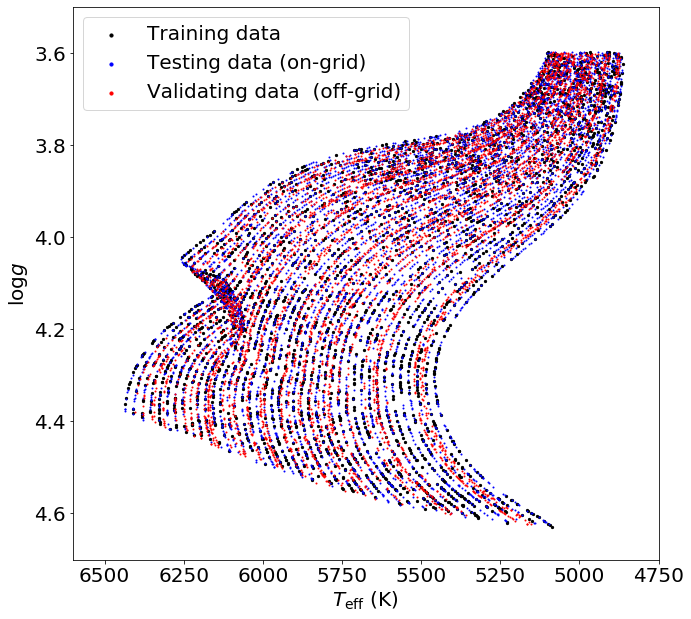

In [15]:
textsize = 20

%matplotlib inline
params = {'legend.fontsize': textsize,
          'figure.figsize': (11, 10),
         'axes.labelsize': textsize,
         'axes.titlesize':textsize,
         'xtick.labelsize':textsize,
         'ytick.labelsize':textsize,
         'font.size': textsize}
matplotlib.rcParams.update(params)

fig, ax = plt.subplots(1,1, figsize = (10,9))
cp = ax.scatter(gdf0['effective_T'], gdf0['log_g'], c = 'k',s = 5) 
ax.scatter(test['effective_T'], test['log_g'], c = 'b',s = 1)
ax.scatter(dfv['effective_T'], dfv['log_g'], c = 'r',s = 1)

ax.scatter(0, 0, c = 'k',s = 10, label = 'Training data')
ax.scatter(0, 0, c = 'b',s = 10, label = 'Testing data (on-grid)')
ax.scatter(0,0, c = 'r',s = 10, label = 'Validating data  (off-grid)')

ax.set_xlabel(r'$T_{\rm eff}$ (K)')
ax.set_ylabel(r'$\log g$')
ax.set_xlim([6600,4750])
ax.set_ylim([4.7,3.5])
ax.legend(fontsize = 20)

#cp = ax[1].scatter(gdf['initial_mass'], gdf['frac_age'], c = 'k',s = 10, label = 'Training data') #,cmap = 'hot')
#ax[1].scatter(dfv['initial_mass'], dfv['frac_age'], c = 'r',s = 10, label = 'Testing data') #,cmap = 'hot')
#ax[1].set_xlabel(r'$M/M_{\odot}$')
#ax[1].set_ylabel(r"$t'$")
fig.tight_layout()
fig.savefig(gmk._savepath + '2d_data_on_HR.pdf')
#ax1.set_title('MESA grid models')

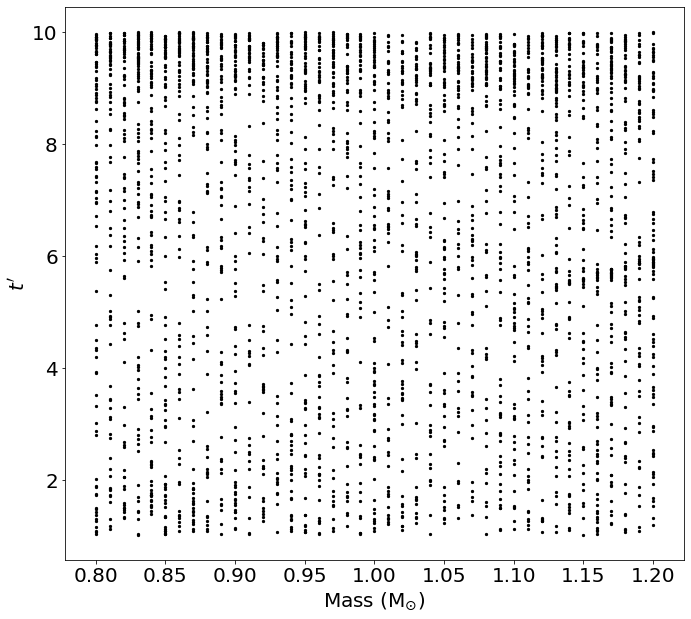

In [17]:
fig, ax = plt.subplots(1,1, figsize = (10,9))
cp = ax.scatter(gdf0['initial_mass'], gdf0['frac_age'], c = 'k',s = 5) 
ax.set_xlabel(r'Mass (M$_{\odot}$)')
ax.set_ylabel(r"$t'$")


#cp = ax[1].scatter(gdf['initial_mass'], gdf['frac_age'], c = 'k',s = 10, label = 'Training data') #,cmap = 'hot')
#ax[1].scatter(dfv['initial_mass'], dfv['frac_age'], c = 'r',s = 10, label = 'Testing data') #,cmap = 'hot')
#ax[1].set_xlabel(r'$M/M_{\odot}$')
#ax[1].set_ylabel(r"$t'$")
fig.tight_layout()
fig.savefig(gmk._savepath + 'M0_data.pdf')
#ax1.set_title('MESA grid models')

In [18]:
# Train and validate
def train_and_validate(gdf, dfv, kname, label):
    print('training ' + label)
    gpm = gmk.gp_a_dataframe(df = gdf, xcolumns = xcolumns, ycolumns = ycolumns, kname = kname)
    #
    np.save(gmk._savepath + label + '_gpm_.npy', gpm.param_array)
    gdf.to_csv(gmk._savepath + label + '_gpm_.csv')
    #    
    print('validating ...')
    gpp = dfv.copy()
    offsets = dfv.copy()
    gpp = gmk.sample_with_df(n = 1, df = dfv, gpm = gpm, 
                             xcolumns = xcolumns, xshift = xshifts, 
                             randomshift = False, ycolumns = ycolumns)
    gpp.to_csv(gmk._savepath + label + '_gpp_.csv')
    offsets[ycolumns] = dfv[ycolumns] - gpp[ycolumns]
    offsets.to_csv(gmk._savepath + label + '_offsets_.csv')
    validations = np.percentile(np.abs(offsets[ycolumns]), [50, 95, 99.8, 100])
    print('Model---50%----95%---99.8%---100%')
    print(label, validations)
    #
    fig, ax = plt.subplots(1,1, figsize = (10,9))
    cp = ax.scatter(dfv['initial_mass'], dfv['frac_age'], c = offsets[ycolumns[0]],s = 10) 
    ax.set_xlabel(r'Mass (M$_{\odot}$)')
    ax.set_ylabel(r"$t'$")
    #ax.set_xlim([7000,4750])
    #ax.set_ylim([4.7,3.7])
    cc = plt.colorbar(cp)
    #cc.set_label(ycolumns[0])
    #ax.set_title(label)
    #ax.legend(fontsize = 20)
    fig.tight_layout()
    fig.savefig(gmk._savepath + label +'validation.pdf')
    
    return gpm, gpp, offsets, validations, fig, ax, cc

training M0_MLP
--- 313.83873772621155 seconds ---
validating ...
Model---50%----95%---99.8%---100%
M0_MLP [ 0.08973069  1.78498763 10.5928598  20.69631822]


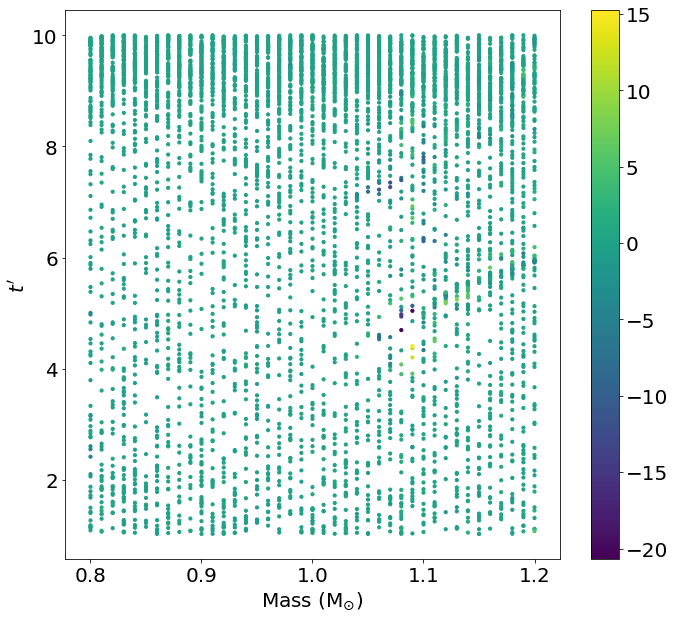

In [19]:
kname = 'MLP'
label = 'M0_' + kname 
gpm0, gpp0, offsets0, validations0, fig, ax, cc = train_and_validate(gdf0, test, kname, label)

Model---50%----95%---99.8%---100%
[ 0.08973069  1.78498763 10.5928598  20.69631822]


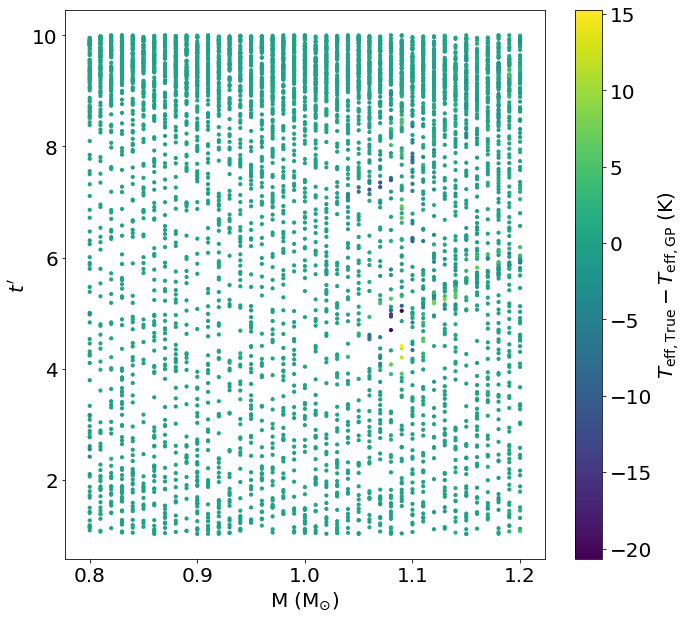

In [21]:
textsize = 20

%matplotlib inline
params = {'legend.fontsize': textsize,
          'figure.figsize': (12, 10),
         'axes.labelsize': textsize,
         'axes.titlesize':textsize,
         'xtick.labelsize':textsize,
         'ytick.labelsize':textsize,
         'font.size': textsize}
matplotlib.rcParams.update(params)
test.index = range(len(test))
gppon = test.copy()
offsetson = test.copy()
gppon = gmk.sample_with_df(n = 1, df = test, gpm = gpm0, 
                             xcolumns = xcolumns, xshift = xshifts, 
                             randomshift = False, ycolumns = ycolumns)
offsetson[ycolumns] = test[ycolumns] - gppon[ycolumns]
validations = np.percentile(np.abs(offsetson[ycolumns]), [50, 95, 99.8, 100])
print('Model---50%----95%---99.8%---100%')
print(validations)

fig, ax = plt.subplots(1,1, figsize = (10,9))
cp = ax.scatter(test['initial_mass'], test['frac_age'], c = offsetson[ycolumns[0]],s = 10) 
ax.set_xlabel(r'M (M$_{\odot}$)')
ax.set_ylabel(r"$t'$")
cc = plt.colorbar(cp)
cc.set_label(r'$T_{\rm eff, True} - T_{\rm eff, GP}$ (K)')
fig.tight_layout()
fig.savefig(gmk._savepath +'M0_ongrid_validation.pdf')

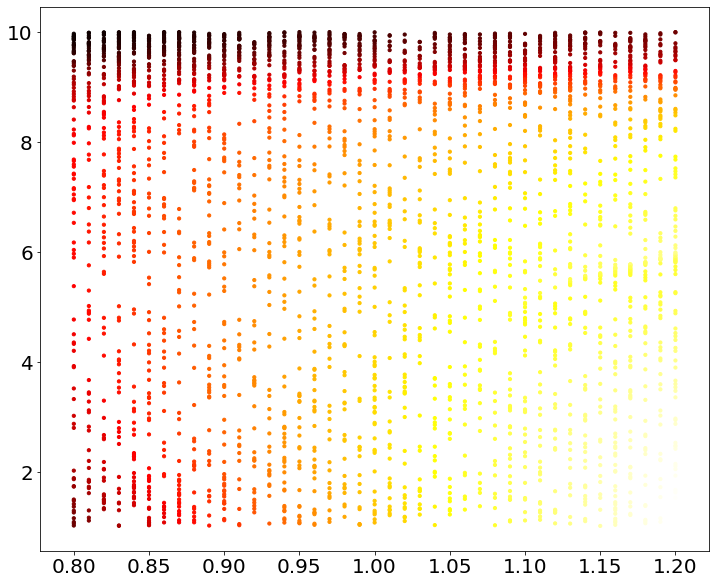

In [22]:
cp = plt.scatter(gdf0['initial_mass'], gdf0['frac_age'], c = gdf0[ycolumns[0]],s = 10, cmap = 'hot')

 /opt/anaconda3/lib/python3.7/site-packages/GPy/plotting/matplot_dep/plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


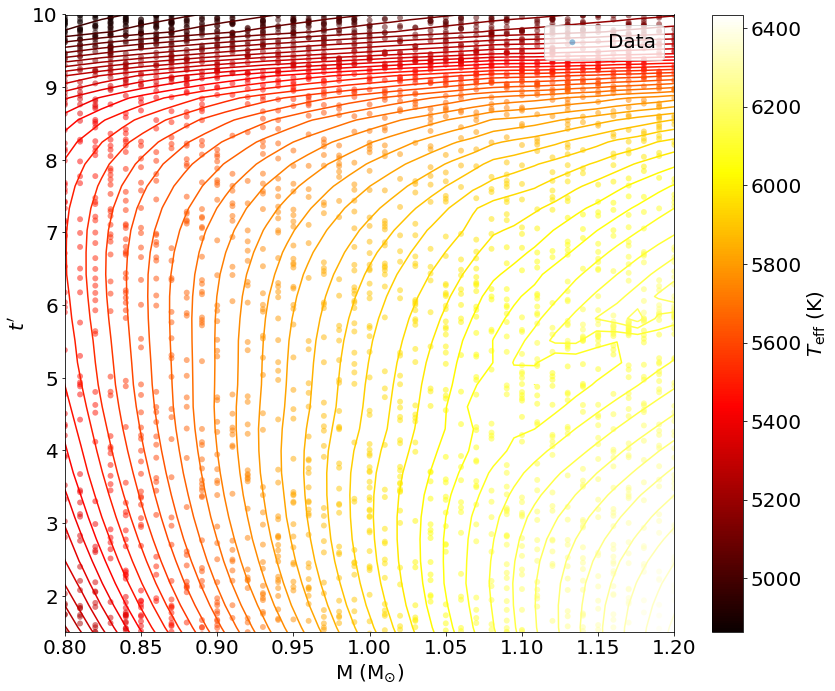

In [23]:
gpm0.plot(levels = 50, cmap = 'winter')
plt.xlabel(r'M (M$_{\odot})$')
plt.ylabel(r"$t'$")
plt.xlim([0.8,1.2])
plt.ylim([1.5,10])
plt.legend(loc = 'upper right')
plt.savefig(savedr + '2d_GPR_model.pdf')
cc = plt.colorbar(cp)
cc.set_label(r'$T_{\rm eff}$ (K)')
plt.savefig(savedr + '2d_gpmodel_MLP.pdf')

 # work on residuls (1-order)

In [262]:
def make_training_data_for_residual(sdf, gpms, label,cmap):
    
    gpp = sdf.copy()
    gdfr = sdf.copy()
    
    for gpm in gpms:
        gpp = gmk.sample_with_df(n = 1, df = sdf, gpm = gpm, 
                                 xcolumns = xcolumns, xshift = xshifts, 
                                 randomshift = False, ycolumns = ycolumns)
        gdfr[ycolumns] = gdfr[ycolumns] - gpp[ycolumns]
    #    
    gdfr['weights'] = np.abs(gdfr[ycolumns])
    gdfr = gdfr.sample(n = ntraining, weights = 'weights', random_state = 99)
    gdfr.to_csv(gmk._savepath + label + '_gdfr_.csv')
    
    fig, ax = plt.subplots(1,1, figsize = (10,9))
    cp = ax.scatter(gdfr['initial_mass'], gdfr['frac_age'], c = gdfr[ycolumns[0]],s = 10, cmap = cmap) 
    ax.set_xlabel(r'M (M$_{\odot}$)')
    ax.set_ylabel(r"$t'$")
    colorbar = plt.colorbar(cp)
    #cc.set_label(ycolumns[0])
    #ax.set_title(label)
    #fig.tight_layout()
    #fig.savefig(gmk._savepath + label +'.png')    
    return gdfr, fig, ax, colorbar

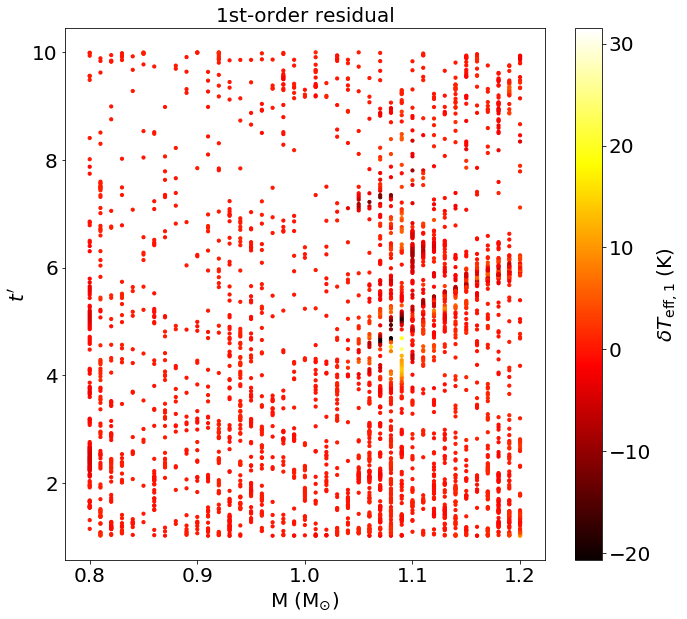

In [213]:
sdf = df.sample(n = nresidual, weights = 'hrgradient', random_state = 139)
sdf.index = range(len(sdf))
gpms = [gpm0]
label = 'M1_data'
gdf1, fig, ax, cc = make_training_data_for_residual(sdf, gpms, label)
cc.set_label(r'$\delta T_{\rm eff, 1}$ (K)')
ax.set_title('1st-order residual')
fig.tight_layout()
fig.savefig(gmk._savepath +'M1_data.pdf') 

training M1_MLP
--- 252.90379214286804 seconds ---
validating ...
Model---50%----95%---99.8%---100%
M1_MLP [0.11325145 1.01413896 4.84293772 7.48079228]
training M1_EXP
--- 163.14582204818726 seconds ---
validating ...
Model---50%----95%---99.8%---100%
M1_EXP [0.08954328 0.86335946 4.06920069 8.63505224]
training M1_RBF
--- 105.51599884033203 seconds ---
validating ...
Model---50%----95%---99.8%---100%
M1_RBF [ 0.08442994  0.96503356  6.67824515 18.67294453]
training M1_RQ
--- 37.295655965805054 seconds ---
validating ...
Model---50%----95%---99.8%---100%
M1_RQ [ 0.13979037  1.7308058   9.21503296 26.6571363 ]
training M1_Mat32
--- 255.12230896949768 seconds ---
validating ...
Model---50%----95%---99.8%---100%
M1_Mat32 [0.06674237 0.71628725 4.36649507 9.82135464]


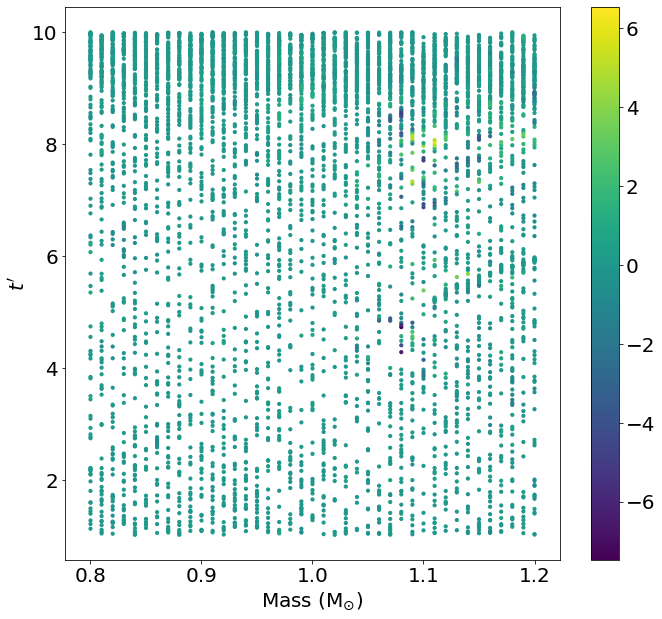

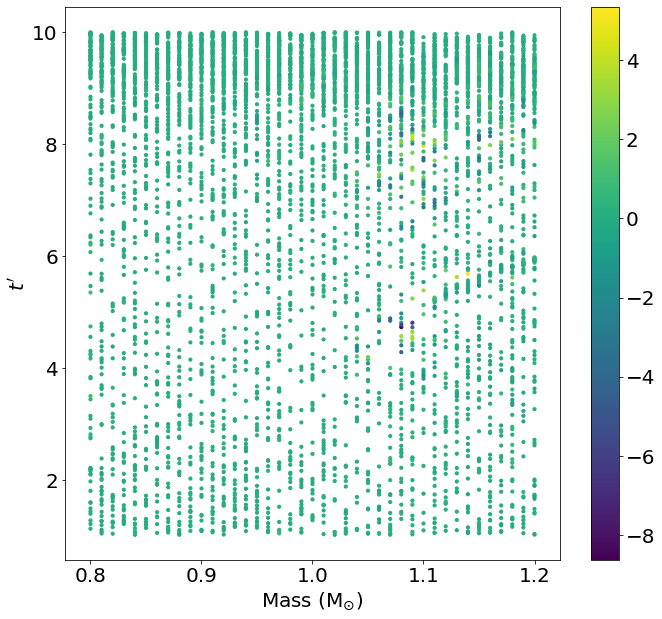

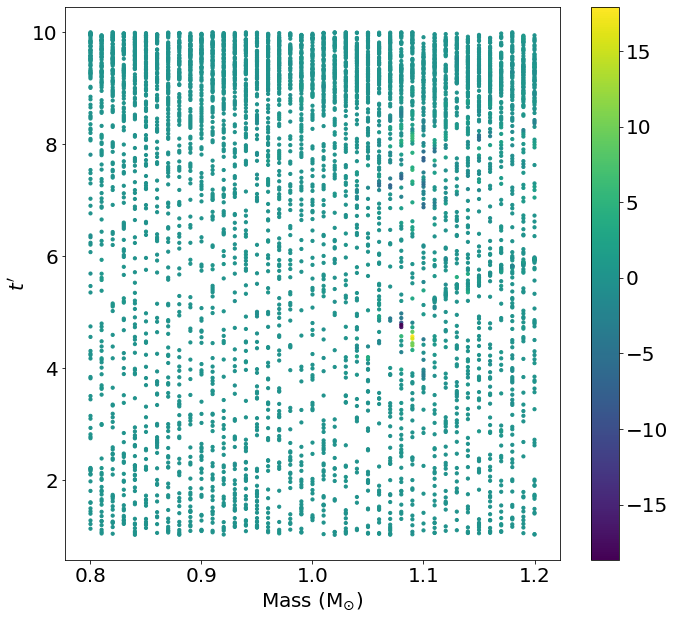

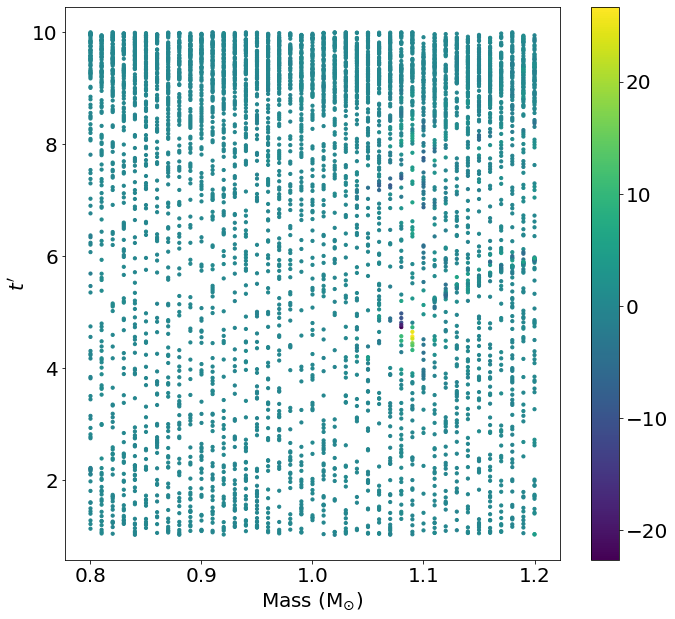

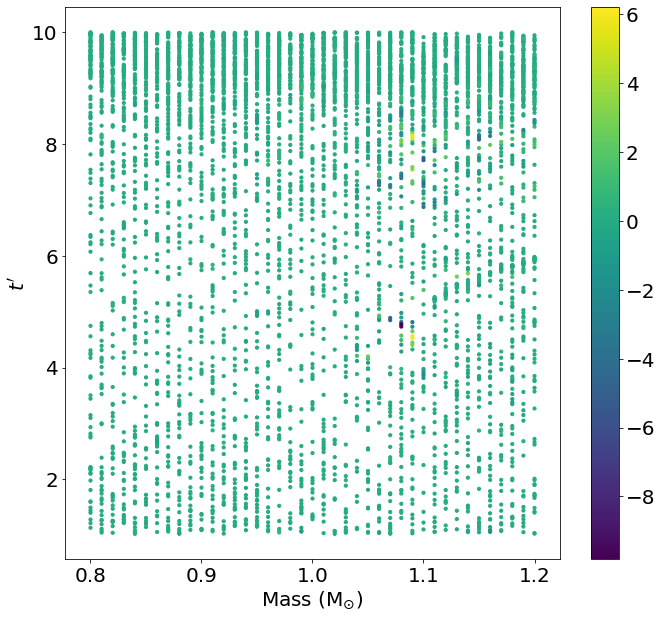

In [216]:
knames = ['MLP', 'EXP', 'RBF', 'RQ', 'Mat32']
for kname in knames:
    label = 'M1_' + kname 
    gpm1, gpp1, offsets1, validations1, fig, ax, cc = train_and_validate(gdf1, offsets0, kname, label)

training M1_MLP
--- 250.45434188842773 seconds ---
validating ...
Model---50%----95%---99.8%---100%
M1_MLP [0.11325145 1.01413896 4.84293772 7.48079228]


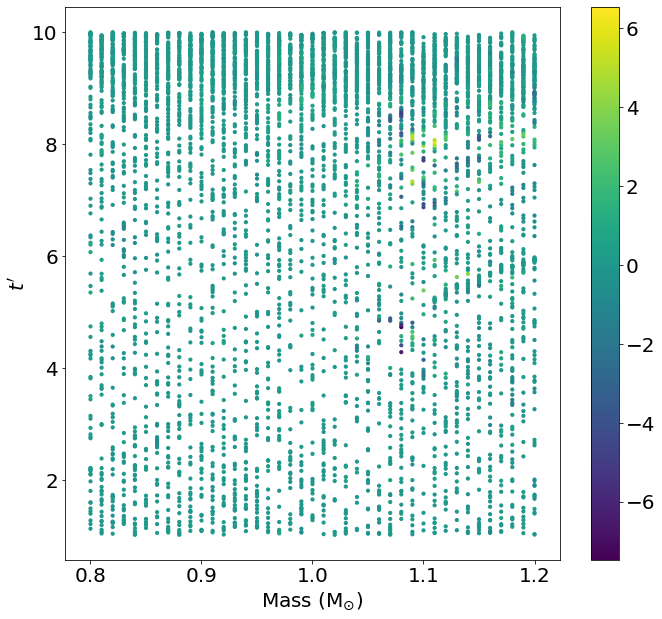

In [222]:
# MLP wins
kname = 'MLP'
label = 'M1_' + kname 
gpm1, gpp1, offsets1, validations1, fig, ax, cc = train_and_validate(gdf1, offsets0, kname, label)

# 2nd-order residuals

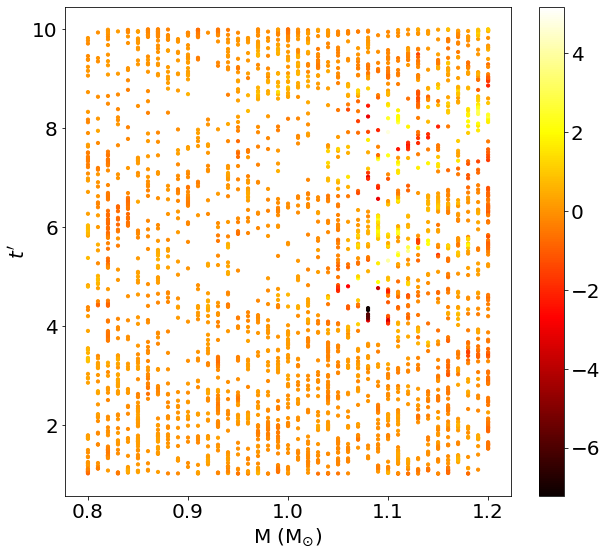

In [229]:
sdf = df.sample(n = nresidual, weights = 'hrgradient', random_state = 887)
sdf.index = range(len(sdf))
gpms = [gpm0,gpm1]
label = 'M2_data'
gdf2, fig, ax, cc = make_training_data_for_residual(sdf, gpms, label)

training M2_MLP
--- 183.0923228263855 seconds ---
validating ...
Model---50%----95%---99.8%---100%
M2_MLP [0.07766478 0.72758483 4.55603723 5.6013762 ]
training M2_EXP
--- 88.13622212409973 seconds ---
validating ...
Model---50%----95%---99.8%---100%
M2_EXP [0.07757054 0.72620279 4.81141651 6.24666005]
training M2_RBF
--- 85.23941898345947 seconds ---
validating ...
Model---50%----95%---99.8%---100%
M2_RBF [0.06349056 0.65051457 3.9075683  6.73786048]
training M2_RQ
--- 36.806243896484375 seconds ---
validating ...
Model---50%----95%---99.8%---100%
M2_RQ [0.14537284 1.09789973 4.44875732 6.19369802]
training M2_Mat32
--- 44.330806732177734 seconds ---
validating ...
Model---50%----95%---99.8%---100%
M2_Mat32 [0.073246   0.68799785 4.18550912 5.72348381]


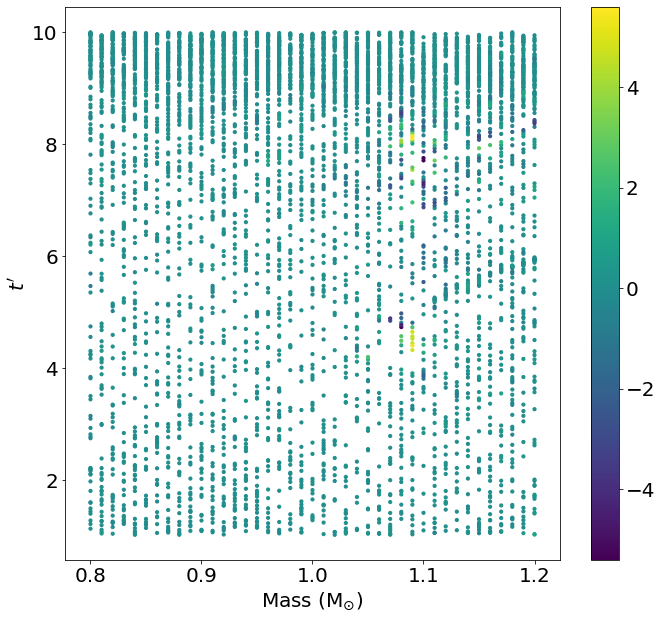

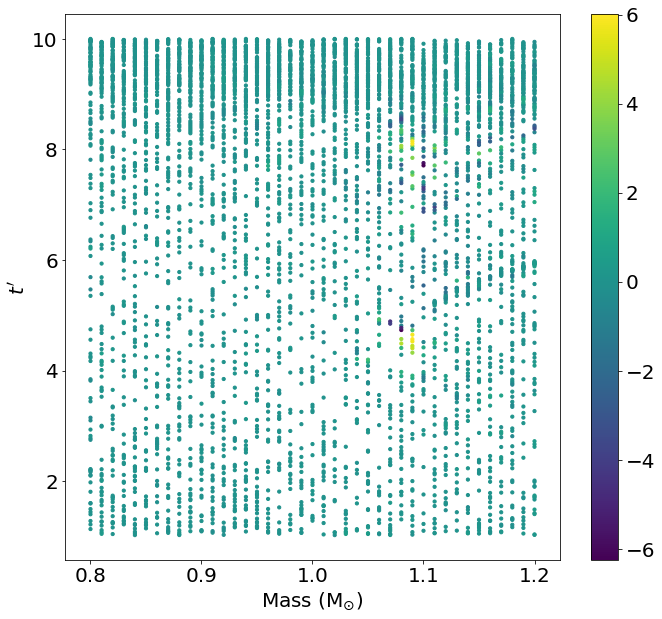

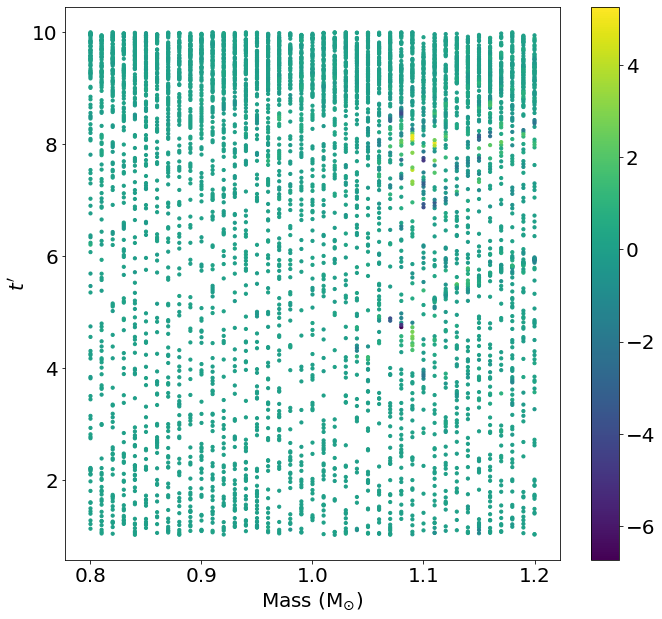

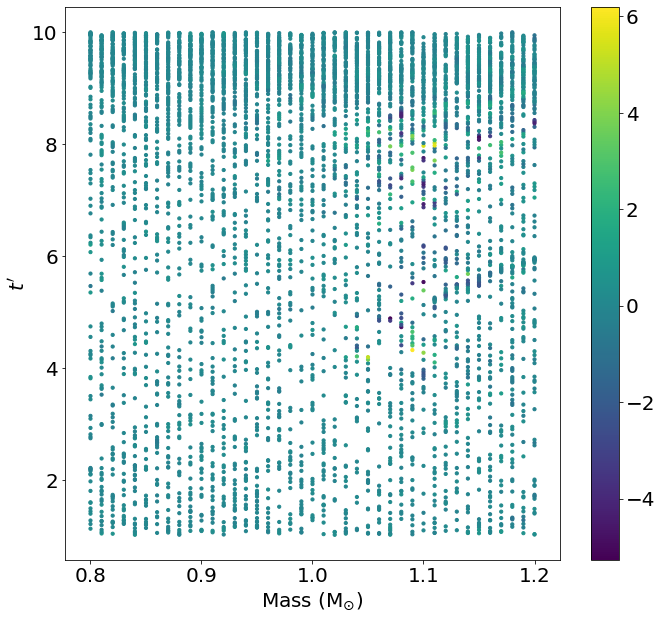

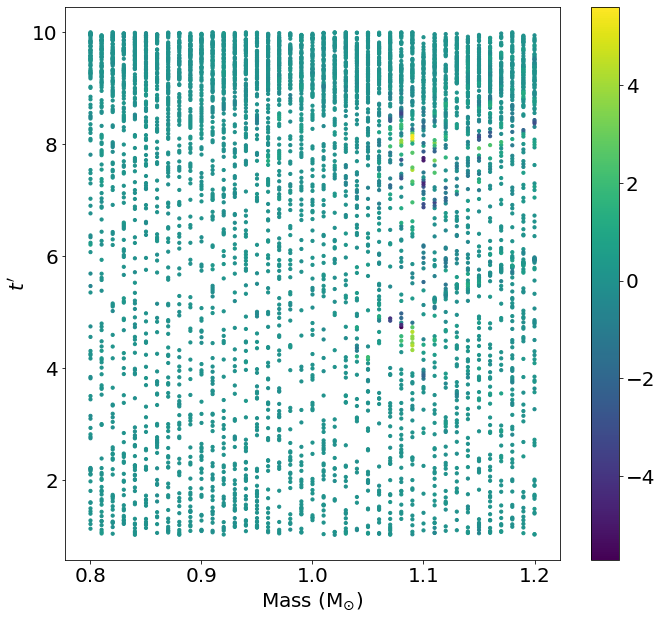

In [230]:
knames = ['MLP', 'EXP', 'RBF', 'RQ', 'Mat32']
for kname in knames:
    label = 'M2_' + kname 
    gpm2, gpp2, offsets2, validations2, fig, ax, cc = train_and_validate(gdf2, offsets1, kname, label)

training M2_RBF
--- 85.88050413131714 seconds ---
validating ...
Model---50%----95%---99.8%---100%
M2_RBF [0.06349056 0.65051457 3.9075683  6.73786048]


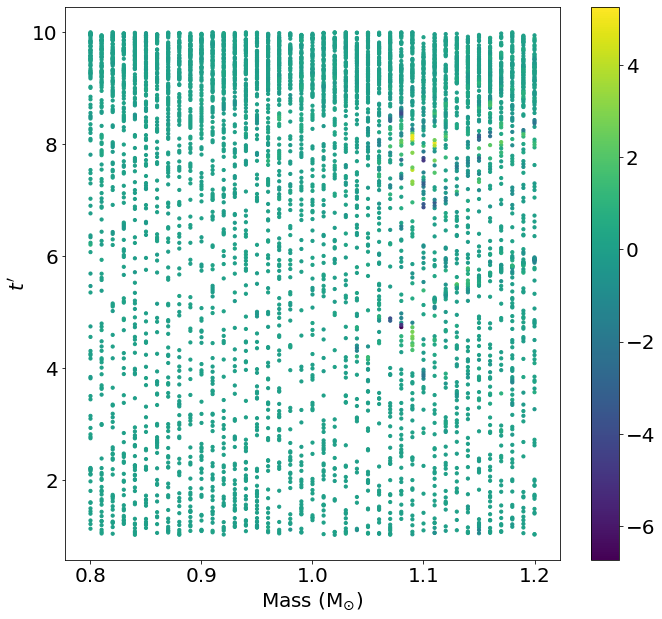

In [231]:
# RBF wins
kname = 'RBF'
label = 'M2_' + kname 
gpm2, gpp2, offsets2, validations2, fig, ax, cc = train_and_validate(gdf2, offsets1, kname, label)

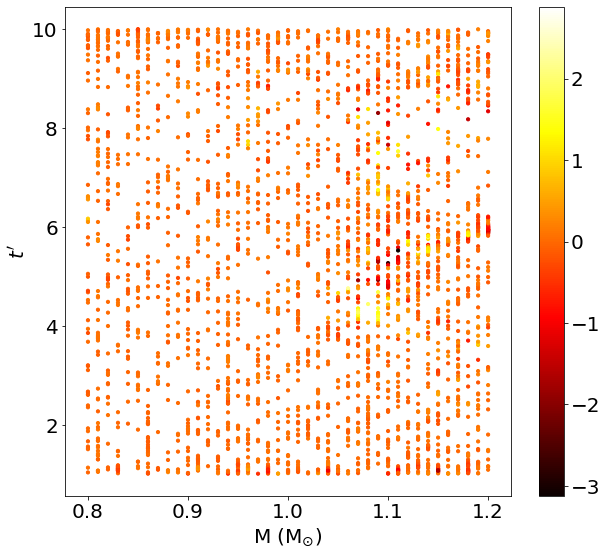

In [232]:
# 3rd-order residual
sdf = df.sample(n = nresidual, weights = 'hrgradient', random_state = 776)
sdf.index = range(len(sdf))
gpms = [gpm0,gpm1,gpm2]
label = 'M3_data'
gdf3, fig, ax, cc = make_training_data_for_residual(sdf, gpms, label)

training M3_MLP
--- 106.63817286491394 seconds ---
validating ...
Model---50%----95%---99.8%---100%
M3_MLP [0.07865481 0.6425717  3.9314063  6.6442331 ]
training M3_EXP
--- 101.02333903312683 seconds ---
validating ...
Model---50%----95%---99.8%---100%
M3_EXP [0.05003453 0.47978184 3.69439659 6.97650889]
training M3_RBF
--- 123.98903918266296 seconds ---
validating ...
Model---50%----95%---99.8%---100%
M3_RBF [0.0436862  0.46950711 3.57829789 6.89610637]
training M3_RQ
--- 131.45556497573853 seconds ---
validating ...
Model---50%----95%---99.8%---100%
M3_RQ [0.0473229  0.47267174 3.59495355 7.0643438 ]
training M3_Mat32
--- 77.35003900527954 seconds ---
validating ...
Model---50%----95%---99.8%---100%
M3_Mat32 [0.04669922 0.48888673 3.50587773 7.08937673]


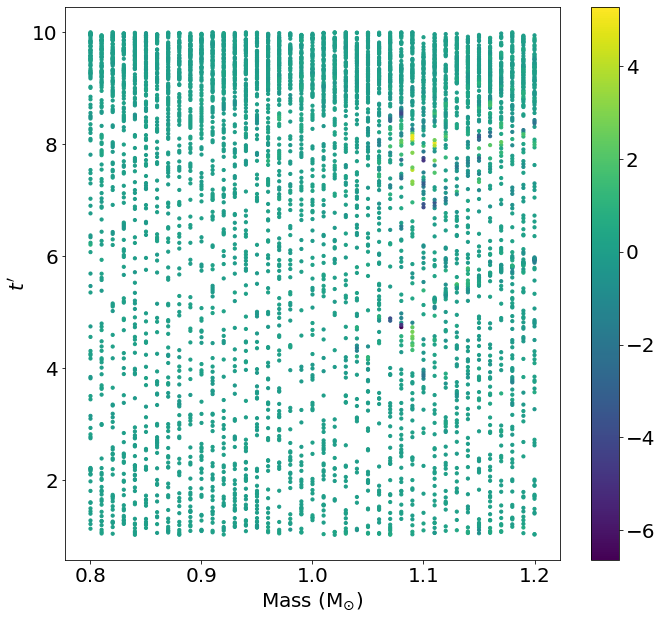

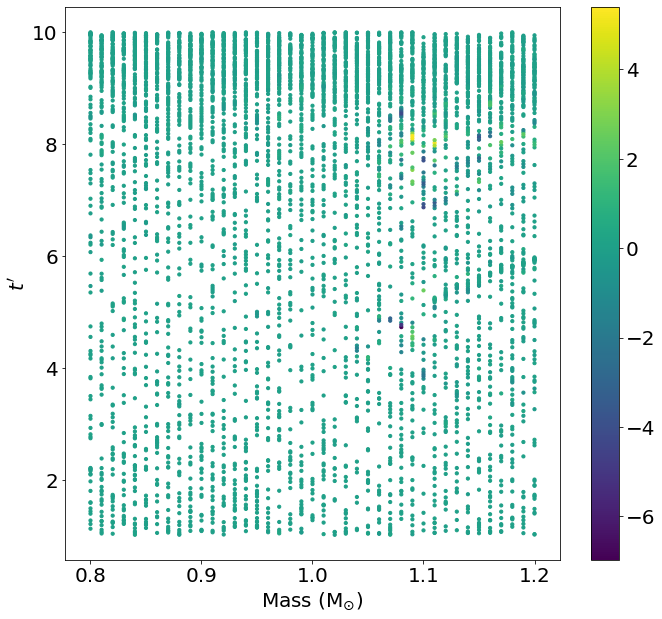

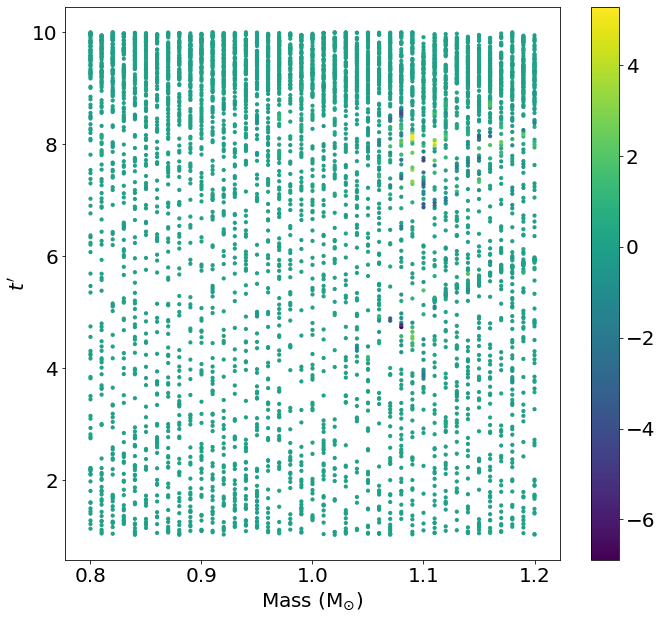

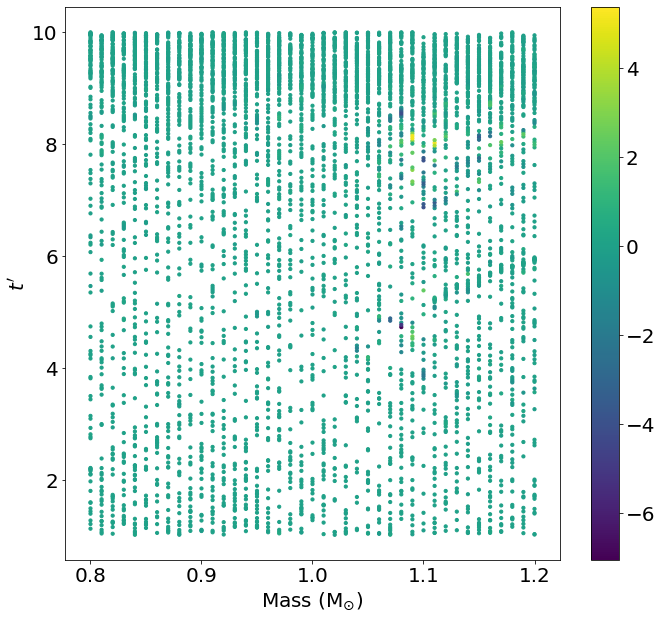

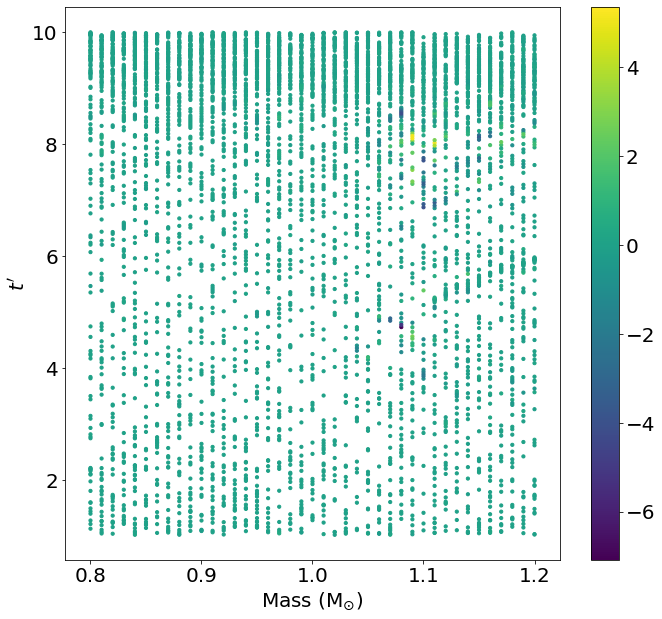

In [233]:
knames = ['MLP', 'EXP', 'RBF', 'RQ', 'Mat32']
for kname in knames:
    label = 'M3_' + kname 
    gpm3, gpp3, offsets3, validations3, fig, ax, cc = train_and_validate(gdf3, offsets2, kname, label)

training M3_RBF
--- 201.84614300727844 seconds ---
validating ...
Model---50%----95%---99.8%---100%
M3_RBF [0.0436862  0.46950711 3.57829789 6.89610637]


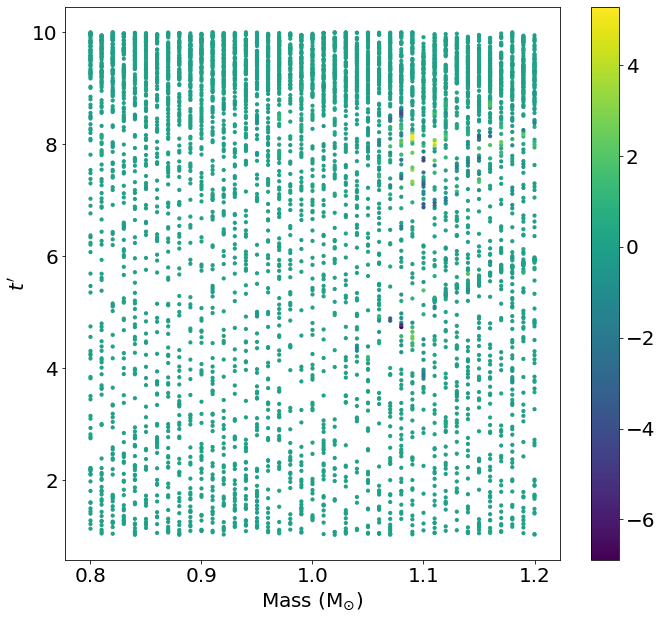

In [234]:
# RBF wins
kname = 'RBF'
label = 'M3_' + kname 
gpm3, gpp3, offsets3, validations3, fig, ax, cc = train_and_validate(gdf3, offsets2, kname, label)

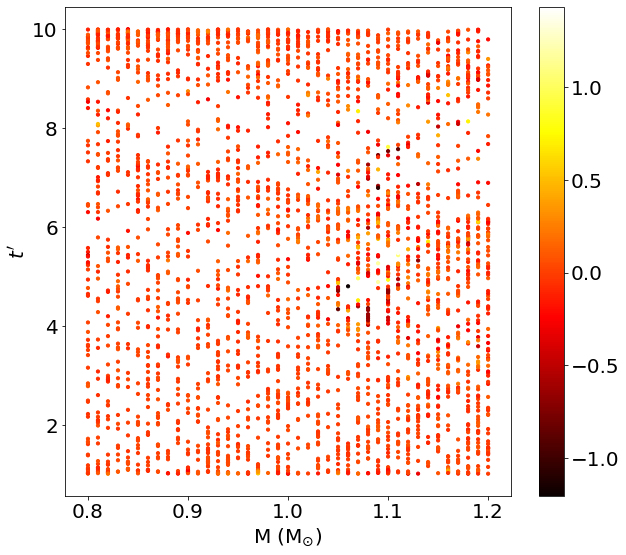

In [240]:
# 4th-order residual
sdf = df.sample(n = nresidual, weights = 'hrgradient', random_state = 654)
sdf.index = range(len(sdf))
gpms = [gpm0,gpm1,gpm2,gpm3]
label = 'M4_data'
gdf4, fig, ax, cc = make_training_data_for_residual(sdf, gpms, label)

training M4_MLP
--- 40.60902404785156 seconds ---
validating ...
Model---50%----95%---99.8%---100%
M4_MLP [0.04398391 0.46917824 3.57782561 6.89569642]
training M4_EXP


 /opt/anaconda3/lib/python3.7/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /opt/anaconda3/lib/python3.7/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /opt/anaconda3/lib/python3.7/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


--- 45.569308042526245 seconds ---
validating ...
Model---50%----95%---99.8%---100%
M4_EXP [0.04122466 0.4445326  3.57051755 6.44142769]
training M4_RBF


 /opt/anaconda3/lib/python3.7/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /opt/anaconda3/lib/python3.7/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


--- 98.36807203292847 seconds ---
validating ...
Model---50%----95%---99.8%---100%
M4_RBF [0.04234839 0.45707244 3.57817438 6.88691481]
training M4_RQ


 /opt/anaconda3/lib/python3.7/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /opt/anaconda3/lib/python3.7/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


--- 158.74435210227966 seconds ---
validating ...
Model---50%----95%---99.8%---100%
M4_RQ [0.03947355 0.43087556 3.57842351 6.89485101]
training M4_Mat32
--- 162.30786275863647 seconds ---
validating ...
Model---50%----95%---99.8%---100%
M4_Mat32 [0.03407225 0.4264397  3.57836019 6.89565883]


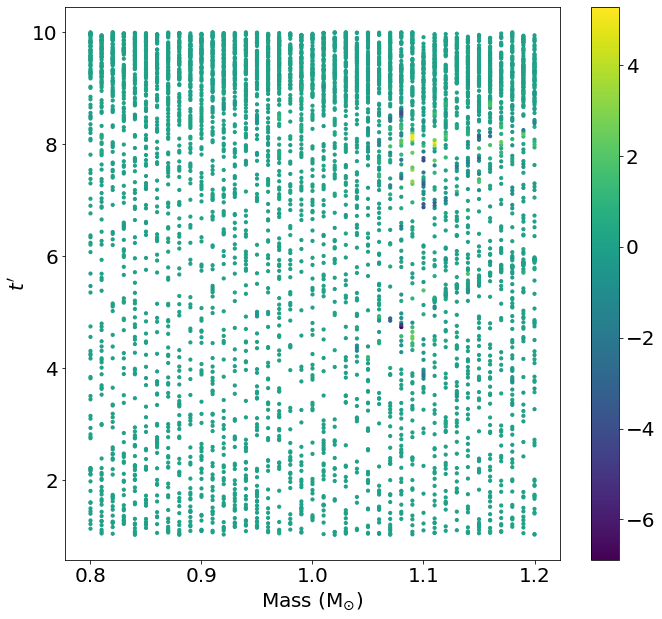

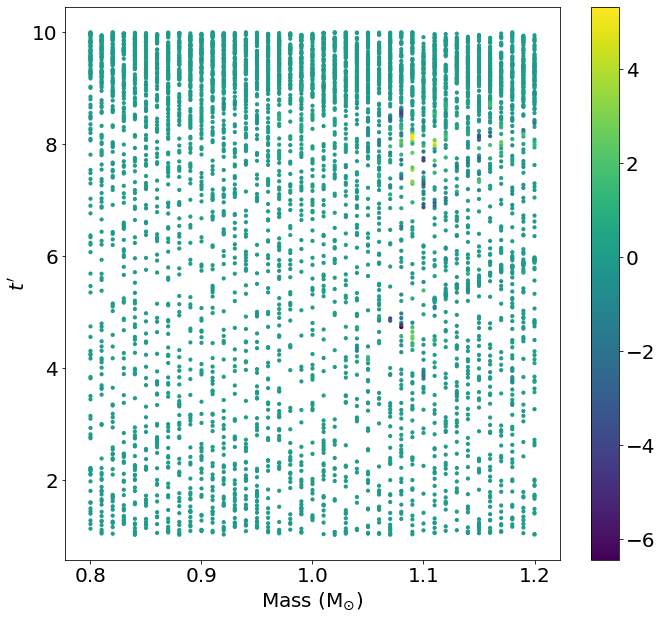

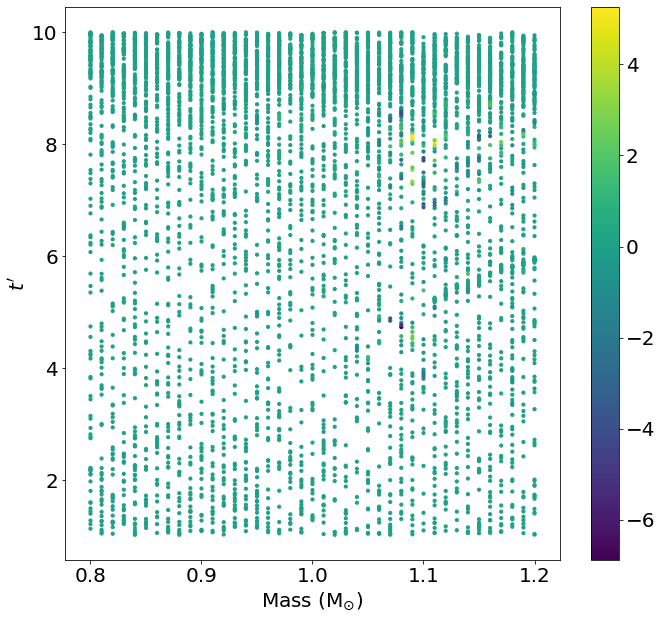

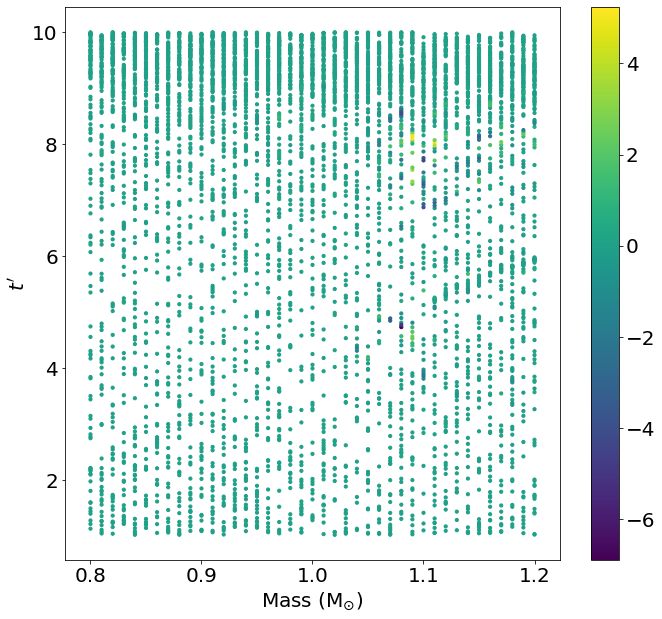

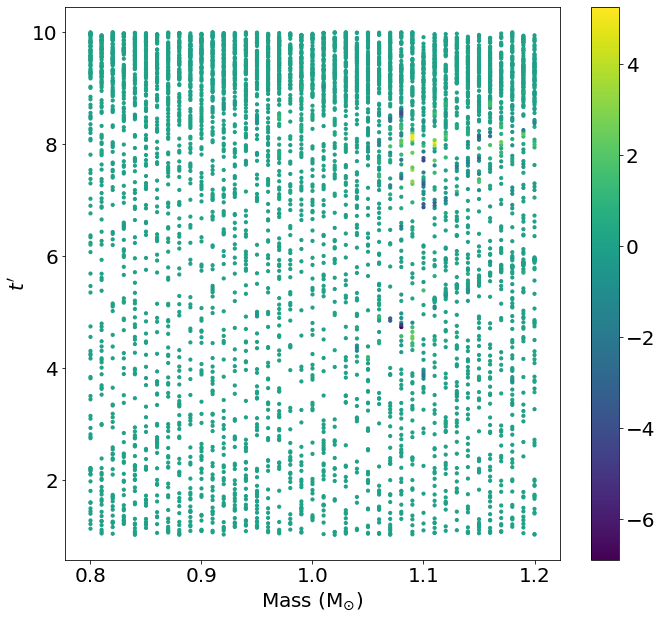

In [241]:
knames = ['MLP', 'EXP', 'RBF', 'RQ', 'Mat32']
for kname in knames:
    label = 'M4_' + kname 
    gpm4, gpp4, offsets4, validations4, fig, ax, cc = train_and_validate(gdf4, offsets3, kname, label)

training M4_Mat32
--- 188.76793718338013 seconds ---
validating ...
Model---50%----95%---99.8%---100%
M4_Mat32 [0.03407225 0.4264397  3.57836019 6.89565883]


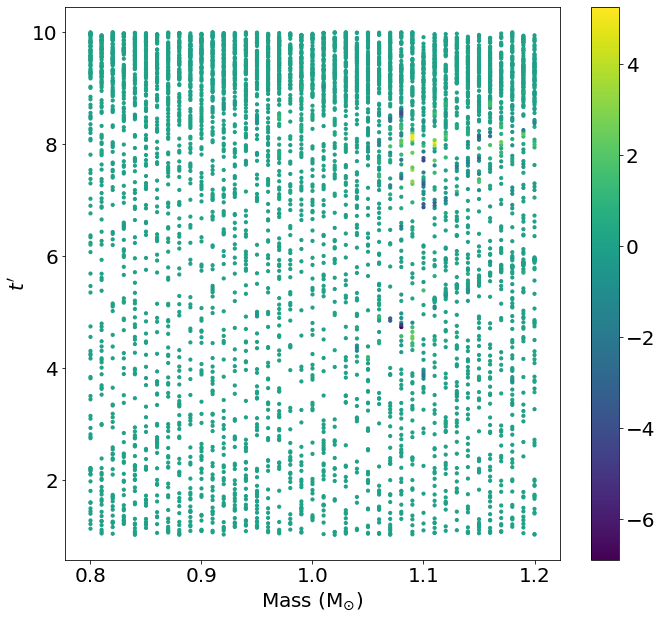

In [244]:
# RQ wins
kname = 'Mat32'
label = 'M4_' + kname 
gpm4, gpp4, offsets4, validations4, fig, ax, cc = train_and_validate(gdf4, offsets3, kname, label)

In [245]:
# final validations

[[ 0.12703831  2.15045608 12.86209544 31.03084226]
 [ 0.11325145  1.01413896  4.84293772  7.48079228]
 [ 0.06349056  0.65051457  3.9075683   6.73786048]
 [ 0.0436862   0.46950711  3.57829789  6.89610637]
 [ 0.03407225  0.4264397   3.57836019  6.89565883]]


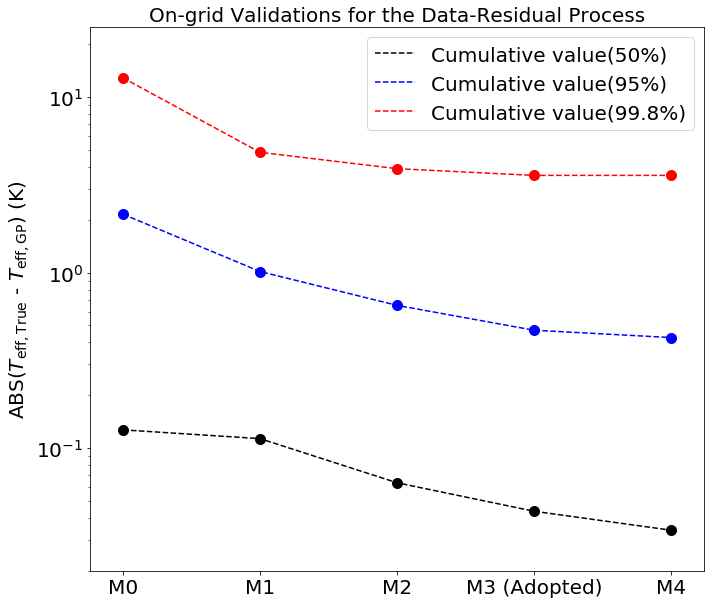

In [292]:
px = np.array([0,1,2,3,4])
pv_on = np.array([validations0, validations1, validations2,validations3,validations4])
print(pv_on)

plt.scatter(px, pv_on[:,0],s = 100,facecolors='k', edgecolors='k') #,label = 'Cumulative value(50%)')
plt.plot(px, pv_on[:,0],'k--',label = 'Cumulative value(50%)')
plt.scatter(px, pv_on[:,1],s = 100,facecolors='b', edgecolors='b') #,label = 'Cumulative value(95%)')
plt.plot(px, pv_on[:,1],'b--',label = 'Cumulative value(95%)')
plt.scatter(px, pv_on[:,2],s = 100,facecolors='r', edgecolors='r') #,label = 'Cumulative value(99.8%)')
plt.plot(px, pv_on[:,2],'r--',label = 'Cumulative value(99.8%)')


plt.yscale('log')
plt.xticks([0,1,2,3,4], ('M0', 'M1', 'M2', 'M3 (Adopted)', 'M4'))
plt.ylim([0.02,25])
plt.title('On-grid Validations for the Data-Residual Process')
plt.ylabel(r'ABS($T_{\rm eff, True}$ - $T_{\rm eff, GP}$) (K)')
plt.legend()
plt.savefig(savedr + 'all_validations.pdf')

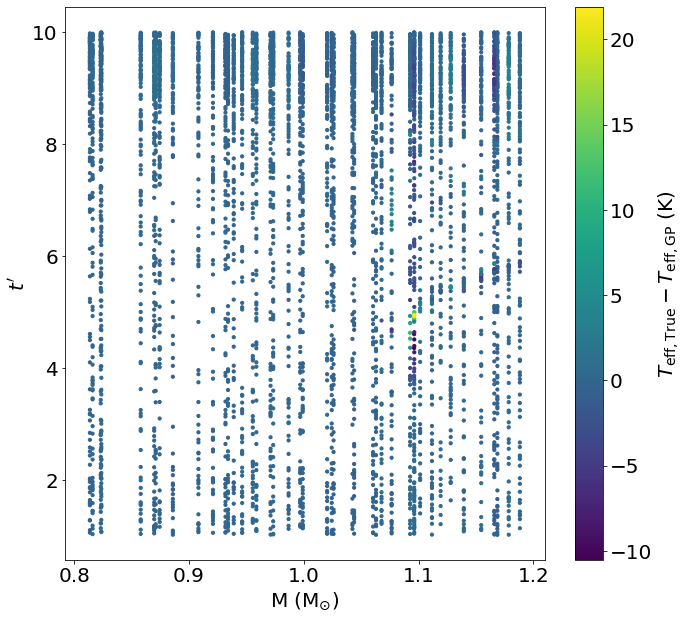

In [293]:
def make_residual(sdf, gpms, cmap):
    
    gpp = sdf.copy()
    gdfr = sdf.copy()
    
    for gpm in gpms:
        gpp = gmk.sample_with_df(n = 1, df = sdf, gpm = gpm, 
                                 xcolumns = xcolumns, xshift = xshifts, 
                                 randomshift = False, ycolumns = ycolumns)
        gdfr[ycolumns] = gdfr[ycolumns] - gpp[ycolumns]
    #    
    gdfr['weights'] = np.abs(gdfr[ycolumns])
    
    fig, ax = plt.subplots(1,1, figsize = (10,9))
    cp = ax.scatter(gdfr['initial_mass'], gdfr['frac_age'], c = gdfr[ycolumns[0]],s = 10, cmap = cmap) 
    ax.set_xlabel(r'M (M$_{\odot}$)')
    ax.set_ylabel(r"$t'$")
    colorbar = plt.colorbar(cp)    
    return gdfr, fig, ax, colorbar

sdf = dfv
sdf.index = range(len(sdf))
gpms = [gpm0, gpm1, gpm2, gpm3]
label = 'M1_data'
gdf1, fig, ax, cc = make_residual(sdf, gpms, cmap = 'viridis')
cc.set_label(r'$T_{\rm eff, True} - T_{\rm eff, GP}$ (K)')
fig.tight_layout()
fig.savefig(gmk._savepath +'off_validation.pdf')


[ 0.33261731  2.59304968 10.53974694 21.894217  ]


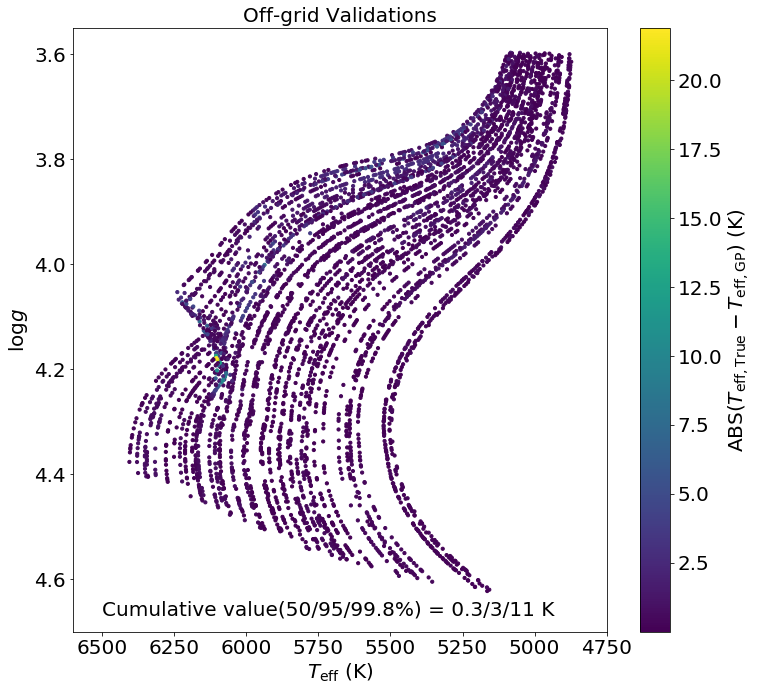

In [294]:
fig, ax = plt.subplots()
cp = ax.scatter(sdf['effective_T'],sdf['log_g'], c = np.abs(gdf1['effective_T']),s =10)
print(np.percentile(np.abs(gdf1[ycolumns]), [50, 95, 99.8, 100]))
ax.set_xlabel(r'$T_{\rm eff}$ (K)')
ax.set_ylabel(r'$\log g$')
ax.set_xlim([6600,4750])
ax.set_ylim([4.7,3.55])
ax.set_title('Off-grid Validations')
#ax.legend(fontsize = 20)
cc = plt.colorbar(cp)
cc.set_label(r'ABS($T_{\rm eff, True} - T_{\rm eff, GP}$) (K)')
plt.text(6500, 4.67, r'Cumulative value(50/95/99.8%) = 0.3/3/11 K')
fig.tight_layout()
fig.savefig(gmk._savepath +'off_validation_hr.pdf')